# CS4465 Open Project

Name - Ritvik Raina

SiD - 55828826

Transfer learning using RESNet50 for covid detection

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os

Init Plugin
Init Graph Optimizer
Init Kernel


## 2. Data Loading & Augmentation

In [2]:
#file path
path = "/Users/ritvikraina/Library/Mobile Documents/com~apple~CloudDocs/College/Courses/CS4465 Bioinformatics/Project/data/dataset3"

In [3]:
train_path = os.path.join(path, "train") #training dircetory

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,
                                   brightness_range=[0.7,1.2],
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   validation_split=0.2) # Split 0.2 of the train data to validation data

In [6]:
Classes = ['Covid', 'Normal']

img_size = 128 #set low due to computation restrcitions
epochs = 10
Batch_Size = 16

In [7]:
# Separate train and validation set using generators

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_size,img_size),
                                              batch_size=Batch_Size,
                                              classes=Classes,
                                              subset='training') # Set as training data

validation_set = train_datagen.flow_from_directory(train_path, # Same directory as training data
                                                   target_size=(img_size,img_size),
                                                   batch_size=Batch_Size,
                                                   classes=Classes,
                                                   subset='validation') # Set as validation data

Found 10431 images belonging to 2 classes.
Found 2606 images belonging to 2 classes.


Now we tally the class-wise numbers of images under training, validation, and test sets.

In [8]:
print ("In train_set ")
for i in range(len (train_set.class_indices)):
    print(Classes[i],list(train_set.classes).count(i))
print ("") 

print ("In validation_set ")
for i in range(len (validation_set.class_indices)):
    print(Classes[i],list(validation_set.classes).count(i))
print ("")

In train_set 
Covid 5467
Normal 4964

In validation_set 
Covid 1366
Normal 1240



### **3. Model Construction & Training**

The model relies vastly on the pre-constructed and pre-trained ResNet50. 

The connection is loaded data -> ResNet50 -> Flatten -> Dropout(0.2) -> Output. After the construction, we freeze the top 2 layers of ResNet50 before compiling. 

A noticeable difference of the model is that I train the transfer learning model all at once, unlike the freeze-train-unfreeze-train procedure studied in class.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [10]:
image_size = (img_size, img_size, 3)
freeze_layers = 2

In [11]:
# Data is ready to be run into the base model, ResNet50, after being loaded & augmented
classifier = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=image_size)

x = classifier.output
x = Flatten()(x)
# Dropout layer
x = Dropout(0.2)(x)
# Dense layer
output_layer = Dense(len(Classes), activation='softmax', name='softmax')(x)

Metal device set to: Apple M1


2022-04-12 15:53:56.615872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 15:53:56.616069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Freeze some layers on top before compiling, with the number of layers as a h-param
new_classifier = Model(inputs=classifier.input, outputs=output_layer)
for layer in new_classifier.layers[:freeze_layers]:
    layer.trainable = False
for layer in new_classifier.layers[freeze_layers:]:
    layer.trainable = True

Conduct model compilation and training.

In [13]:
# Complie the model
new_classifier.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])

new_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Visualizing the layers

In [14]:
#callback to save best model weights
checkpoint_path = 'training_2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [15]:
# Train the model
history = new_classifier.fit(train_set,
                             batch_size=Batch_Size,
                             validation_data = validation_set,
                             workers=4,
                             callbacks=[checkpoint],
                             epochs = epochs)

2022-04-12 15:54:08.763472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 15:54:08.764821: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-04-12 15:54:10.805166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


652/652 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.8239

2022-04-12 15:57:36.392160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


652/652 [==============================] - 224s 328ms/step - loss: 0.5569 - accuracy: 0.8239 - val_loss: 0.6692 - val_accuracy: 0.6316
Epoch 2/10
652/652 [==============================] - 256s 392ms/step - loss: 0.2895 - accuracy: 0.9044 - val_loss: 0.8907 - val_accuracy: 0.9528
Epoch 3/10
652/652 [==============================] - 277s 425ms/step - loss: 0.2386 - accuracy: 0.9246 - val_loss: 0.7713 - val_accuracy: 0.8868
Epoch 4/10
652/652 [==============================] - 289s 442ms/step - loss: 0.2884 - accuracy: 0.9254 - val_loss: 0.3349 - val_accuracy: 0.8776
Epoch 5/10
652/652 [==============================] - 298s 456ms/step - loss: 0.2412 - accuracy: 0.9334 - val_loss: 0.2734 - val_accuracy: 0.9225
Epoch 6/10
652/652 [==============================] - 297s 455ms/step - loss: 0.2700 - accuracy: 0.9362 - val_loss: 0.4639 - val_accuracy: 0.8569
Epoch 7/10
652/652 [==============================] - 312s 478ms/step - loss: 0.2120 - accuracy: 0.9355 - val_loss: 0.1971 - val_accura

In [16]:
# save the model 
model_path = "model-resnet50-trained.h5"
new_classifier.save(model_path)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### **4. Model Evaluation**

After the training finishes, run the validation and test data through the model to obtain loss function values and accuracy scores. 

This section also contains the single-image prediction algorithm and some visualizations on model performance.

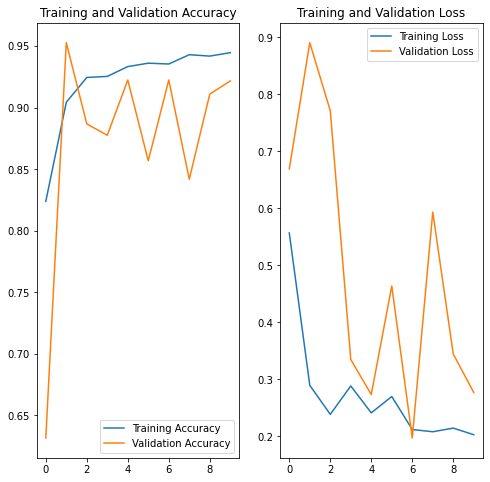

In [18]:
#visualize the model training accuracy and loss over epochs

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Validation accuracy
new_classifier.load_weights(checkpoint_dir)
new_classifier.evaluate(validation_set)

163/163 [==============================] - 25s 156ms/step - loss: 1.2505 - accuracy: 0.9517


[1.2504961490631104, 0.951650083065033]

#### **Single-image Prediction**

Create a dictionary that maps the file name of the image to its class, so that after randomly drawing an image file, we can load and run the image through the model, and meanwhile retrieving the true label from the dictionary.

In [19]:
label_dict = train_set.class_indices  # we can match the label indices and their names
label_dict = {val:key for key, val in label_dict.items()}
label_dict 

{0: 'Covid', 1: 'Normal'}

In [20]:
from tensorflow.keras.models import load_model
classifier_model = load_model(model_path) # load the model 

In [21]:
root_dir = train_path
folders = Classes
filenames = []
file_dict = {}

# Create the dictionary for mapping filename with label
for folder in folders:
    files = os.listdir(f'{root_dir}/{folder}')
    for lung_img in files:
        filenames.append(lung_img)
        file_dict[lung_img] = folder

In [22]:
from keras.preprocessing import image

In [23]:
def Image_and_Prediction():
    # Randomly draw one image and print it out
    sample = np.random.choice(filenames)
    print(sample)
    folder_name = file_dict[sample]
    img_path = f'{root_dir}/{folder_name}/{sample}'
    img = image.load_img(img_path)
    plt.imshow(img)
    
    # Run the randomly drawn image through the model and get results 
    test_image = image.load_img(img_path, target_size=image_size)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    result = classifier_model.predict(test_image).astype(int)
    result = [1 if x == max(list(result)[0]) else 0 for x in list(result)[0]]
    result_label = label_dict[list(result).index(1)] if 1 in list(result) else 'no prediction'
    print(list(result))
    print('predicted: ',result_label)
    print('true: ',folder_name)

14_Jun_coronacases_case10_203.png


2022-04-12 16:42:22.929608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[1, 0]
predicted:  Covid
true:  Covid


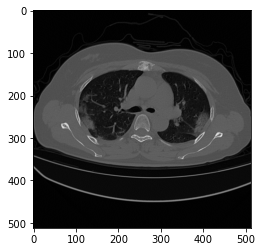

In [24]:
Image_and_Prediction()

#### **Visualization of Model Performance**

In this section, we plot a heatmap for the confusion matrix and print out the classification report so that we can have more insights into the model.

In order to sync the sequences of true labels and predicted labels, we iteratively append those labels by loading images one-by-one from the folders. More efficient codes could be implemented for this function.

In [25]:
res_idx, res_lbl = [], []

for filename in filenames:
    folder_name = file_dict[filename]
    root_dir = os.path.join(path,"train")
    img_path = f'{root_dir}/{folder_name}/{filename}'
    test_image = image.load_img(img_path, target_size=image_size)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    result = classifier_model.predict(test_image).astype(int)
    result = [1 if x == max(list(result)[0]) else 0 for x in list(result)[0]]
    result_idx = list(result).index(1)
    res_idx.append(result_idx)
    result_label = label_dict[list(result).index(1)] if 1 in list(result) else 'no prediction'
    res_lbl.append(result_label)

y_true = list(file_dict.values())
y_pred = res_lbl

In [34]:
# Print the classification report
from sklearn.metrics import confusion_matrix, classification_report
print('----------------CLASSIFICATION REPORT----------------')
print(classification_report(y_true, y_pred))

----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

       Covid       0.52      1.00      0.69      6833
      Normal       0.00      0.00      0.00      6204

    accuracy                           0.52     13037
   macro avg       0.26      0.50      0.34     13037
weighted avg       0.27      0.52      0.36     13037



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

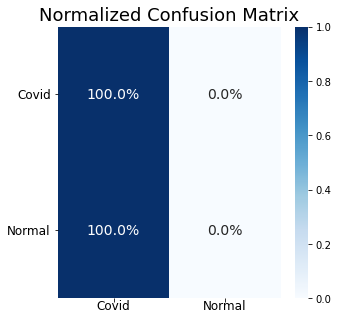

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_true, y_pred, normalize='true'),
            fmt='.1%',
            annot=True,
            cmap="Blues",
            xticklabels=folders,
            yticklabels=folders,
            annot_kws={"size": 14})
plt.title('Normalized Confusion Matrix', {'fontsize':18})
plt.yticks(np.arange(2)+0.5,rotation=0, fontsize="12", va="center")
plt.xticks(np.arange(2)+0.5,rotation=0, fontsize="12", va="center")
plt.show()